# Parcours recherche: Aymane El Firdoussi: Sampling methods

-----
## Author

This notebook was created by **Aymane El Firdoussi** 

----


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# All imports go here

----
## Part 1 : Preliminaries

We start by defining the functions that we will need along this project, for instance the gradient of a function, some kernels, etc.


### Gradient:

In [2]:
def gradient_1d(f ,x ,h): # dérivée par la méthode des différences finies
    return (f(x+h) - f(x)) / h

def gradient(F, x ,h): # Gradient en multidimension
    # Get the dimension of the vector x
    try:
        d = len(x)
    except:
        d = 1 
    
    # the gradient vector (Jacobian)
    G = np.zeros(d)
    
    for i in range(d):
        H =  np.zeros(d)
        H[i] = h
        g = (F(x + H) - F(x)) / h # la ieme dérivée partielle
        G[i] = g
        
    return np.array(G)

# Gaussian density
def gauss(x, mean, sigma):
    norm = (x - mean) ** 2
    return np.exp(- norm / ( 2 * sigma**2 )) / np.sqrt(2 * np.pi * sigma**2)
    


### Data generation

We will define a function that will generate samples following a uniform law on $[a, b]$ : $\mathcal{U}([a, b])$

In [3]:
def gen_unif(N, d, low, high):
    x = []
    for i in range(N):
        x.append(np.random.uniform(low , high, size=d))
    return np.array(x)


----
###  Kernels

Along this project, we will be using these kernels:
- **Gaussian Kernel** given by:
$$ K(x, y) = \exp(- \frac{\| x - y \|^2}{2 \sigma^2}) $$

Its gradient is given by :

$$ \nabla_x K(x, y) = - \frac{K(x, y)}{\sigma^2} (x - y) $$

This kernel is associated to the Reproducing Kernel Hilbert Space (RKHS):
$$ H = adh( \{ \sum_{i = 1}^n \alpha_i k(x_i, .) , \alpha_1, ..., \alpha_n\}) $$
Which is the Hilbert space of functions that can be written as a finite combiantion of Gaussian kernels.

- The space of **band limited** functions in $ L^2(\mathbb{R})$ :
$$ H = \{ f \in \mathcal{C}(\mathbb{R}) | Supp(f) \subset [-a, a] \} $$
is a reproducting kernel hilbert space with **Reproducing Kernel**:

$$ K(x, y) = \frac{\sin(a(x - y))}{\pi (x - y)} $$

Its derivative is given by: (it is symmetric)

$$ \frac{\partial K}{\partial x} = \frac{a(x - y) \cos(a(x - y)) - \sin(a (x - y))}{\pi (x - y)^2 }  $$

----

In [4]:
# Gaussian kernel and its gradient (RBF)
def gauss_kernel(x, y, sigma): 
    norm = np.sum((x - y) ** 2)
    return np.exp(- norm / ( 2 * sigma**2 )) 

def gr_gauss_kernel(x, y, sigma): # Gradient du RBF par rapport a x
    return - gauss_kernel(x, y, sigma) * (x - y) / sigma**2

# Kernel of band limited continuous functions
def band_kernel(x, y, a):
    if abs(x - y) < 1e-15:
        return a / np.pi
    else:
        return np.sin(a * (x - y)) / (np.pi * (x - y))

def gr_band_kernel(x, y, a):
    num1 = a * (x - y) * np.cos(a * (x - y))
    num2 = np.sin(a * (x - y))
    if abs(x - y) < 1e-15:
        return 1e10 # l'infini
    
    return num1 - num2 / (np.pi * (x - y)**2)


----
## Estimators of moments

- We will define the unbiased estimators of the mean and the variance


In [5]:
# Estimator of mean
def empirical_mean(x):
    N = len(x)
    return np.sum(x) / N

# Unbiased estimator of the variance
def empirical_variance(x):
    N = len(x)
    return np.sum((x - empirical_mean(x))**2) / (N - 1)


---
### Test of the gradient function

In [6]:
# Test de la fonction gradient
def F(x):
    return gauss_kernel(x,0,1)

# Il faut trouver que gradient = gr_gauss_kernel à peu près
h = 1e-10
x = np.array([1, 2])
G = gradient(F, x, h)
gk = gr_gauss_kernel(x, 0, 1)
print(G)
print(gk)
print("Bonne approximation !")

[-0.08208503 -0.16417007]
[-0.082085 -0.16417 ]
Bonne approximation !


----
## Part 2: SVGD Implementing using the RBF Kernel

The parameters of the function SVGD are
- V : Potential function
- X : matrix of shape Nxd (N rows et d columns) such that each row contain a vector of our data
- h : gradient step (argument of the function **gradient**)
- maxit : The maximum number of iterations
- lam : learning rate
- sigma: parameter in the RBF kernel


In [9]:
def SVGD_gauss(V, X, h, lam, a, maxit): 
    #trajectory = []
    #trajectory.append(list(X))  
    # la configuration finale
    Xf = X.copy() 
    
    # Current iteration
    t = 0 
    
    # Length of the data set
    N = len(X)
    try:
        d = len(X[0])
    except:
        d=1
    
    # SVGD Algorithm
    while t < maxit:
        for i in range(N): # update data
            s = 0
            for j in range(N):
                s += gradient(V, Xf[j], h) * gauss_kernel(Xf[i], Xf[j], sigma) - gr_gauss_kernel(Xf[j],Xf[i],sigma)
            Xf[i] = Xf[i] - (lam / N) * s
        t += 1
        
    #trajectory.append(list(Xf))
    return Xf


In [10]:
def SVGD_band(V, X, h, lam, a, maxit):
    #trajectory = []
    #trajectory.append(list(X))  
    # la configuration finale
    Xf = X.copy() 
    
    # Current iteration
    t = 0 
    
    # Length of the data set
    N = len(X)
    try:
        d = len(X[0])
    except:
        d=1
    
    # SVGD Algorithm
    while t < maxit:
        for i in range(N): # update data
            s = 0
            for j in range(N):
                s += gradient(V, Xf[j], h) * band_kernel(Xf[i], Xf[j], a) - gr_band_kernel(Xf[j],Xf[i],a)
            Xf[i] = Xf[i] - (lam / N) * s
        t += 1
        
    #trajectory.append(list(Xf))
    return Xf

## $$ \mathcal{Complexity} $$

If we denote by $m$ the total number of iterations of the algorithm and by $N$ the total number of data points, then we can eaily conclude that the complexity of this version of SVGD is : $$ \mathcal{O}(N^2 m) $$

---

----
### Testing the algorithm in dimension d=1 with N = 200 and 200 iterations

- We will generate samples following a uniform law.
- Then we will perform SVGD on them to see if they will converge to a Gaussian Law


In [11]:
# Target potential
def potential_N21(x): 
    num = np.sum((x - 2.0)**2)
    return num / 2

def gauss_1d(x, mean, std):
    return np.exp(- (x - mean)**2 / (2 * std**2)) / (std * np.sqrt(2 * np.pi))


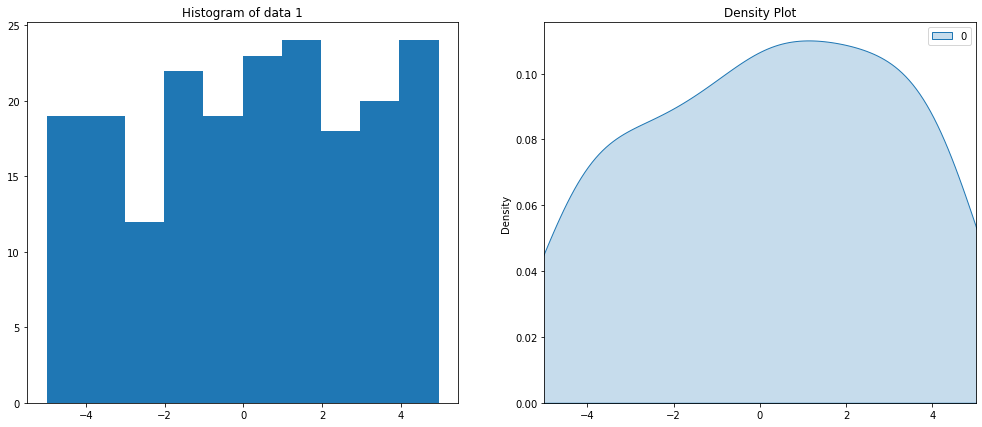

In [22]:
# Simulation of uniform density in [-5, 5]
X = gen_unif(200, 1, -5, 5)

# Plotting data
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(X)
axs[0].set_title('Histogram of data 1')

# Plot the third scatter plot in the right subplot
sns.kdeplot(data=X, fill=True, ax=axs[1], bw_method='silverman')
axs[1].set_xlim((-5, 5))
axs[1].set_title('Density Plot')

# Show the plot
plt.show()

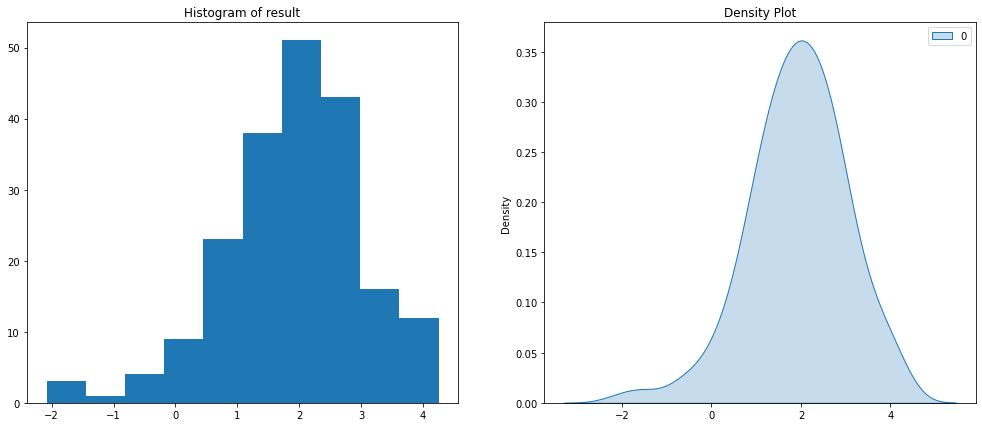

In [25]:
# Parameters of the SVGD
h = 1e-6
lam = 0.1
sigma = 1
maxit = 200

# Performing SVGD
xf = SVGD_gauss(potential_N21, X, h, lam, sigma, maxit) # expected time : 4m (for 200 iteration)

# Plotting the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(xf)
axs[0].set_title('Histogram of result')

# Plot the third scatter plot in the right subplot
sns.kdeplot(data = xf, fill=True, ax=axs[1], bw_method='silverman')
axs[1].set_title('Density Plot')

# Show the plot
plt.show()

## $$ \mathcal{Comparison} $$


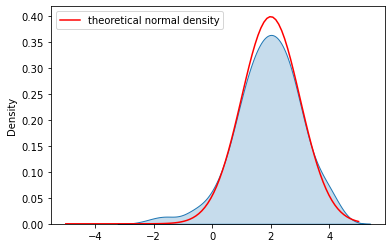

In [29]:
# Now the density of particles obtaned by applying SVGD to them
sns.kdeplot(data=xf, fill=True)
t = np.linspace(-5, 5, 100)
y = gauss_1d(t, 2, 1)
plt.plot(t, y, color="red", label="theoretical normal density")
plt.legend()
plt.show()

----
## $$\mathcal{Estimators} $$


In [30]:
# Values of estimation
print("The empirical mean is : ", empirical_mean(xf))
print("The empirical variance is : ", empirical_variance(xf))

The empirical mean is :  1.9191924514469583
The empirical variance is :  1.216418670606952


----
# Next approaches:
In the next sections, we will discuss
- The influence of the number of iterations
- The influence of the total number of samples
- The influence of the initial distribution : **theory** : if we use the Gaussian kernel, we should use a normal distribution as an initial distribution $\mu_0$, and if we use the uniform distribution as initial one, we can use the other kernel that we stated before.
- The influence of the learning rate


----
## The influence of the number of iterations
We will fix the number of samples to **100**


## !! Do not run !! (approx 10 min to converge)

In [38]:
# data
X = gen_unif(100, 1, -5, 5)

# Iterations
iters = [50, 100, 200, 500, 1000]
var_estim = []
mean_estim = []

# Performing estimations
h = 1e-6
lam = 0.1
sigma = 1

for n in iters:
    y = SVGD_gauss(potential_N21, X, h, lam, sigma, n)
    mean_estim.append(empirical_mean(y))
    var_estim.append(empirical_variance(y))


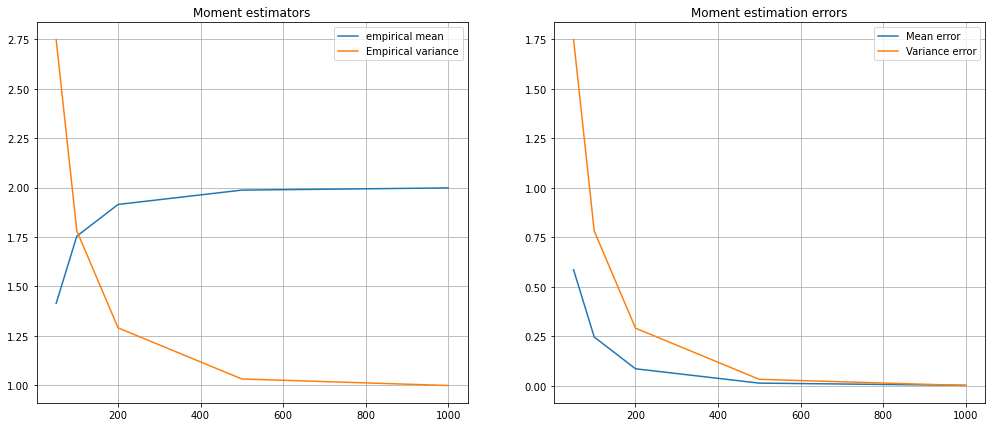

In [39]:
# Plotting results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plotting the results of the estimations
axs[0].plot(iters, mean_estim, label = "empirical mean")
axs[0].plot(iters, var_estim, label = "Empirical variance")
axs[0].set_title('Moment estimators')
axs[0].legend()
axs[0].grid()

# Plotting the error of estimation
mean_error = abs(2 - np.array(mean_estim))
var_error = abs(1 - np.array(var_estim))

axs[1].plot(iters, mean_error, label = "Mean error")
axs[1].plot(iters, var_error, label = "Variance error")
axs[1].set_title('Moment estimation errors')
axs[1].legend()
axs[1].grid()

# Show the plot
plt.show()


----
## The influence of the number of samples

The number of samples contributes in the moment estimators by the Law of Large Numbers. Hence we will observe its influence for a **fixed number of iterations of 100**.


In [40]:
# Samples
n_samples = [50, 100, 150, 200, 300]
var_estim = []
mean_estim = []

# Performing estimations
h = 1e-6
lam = 0.1
sigma = 1

for N in n_samples:
    X = gen_unif(N, 1, -5, 5)
    y = SVGD_gauss(potential_N21, X, h, lam, sigma, 100)
    mean_estim.append(empirical_mean(y))
    var_estim.append(empirical_variance(y))

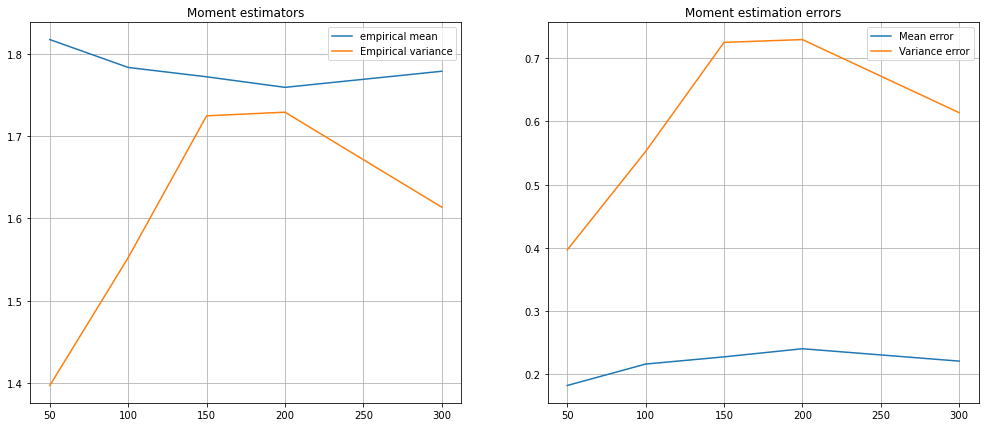

In [41]:
# Plotting results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plotting the results of the estimations
axs[0].plot(n_samples, mean_estim, label = "empirical mean")
axs[0].plot(n_samples, var_estim, label = "Empirical variance")
axs[0].set_title('Moment estimators')
axs[0].legend()
axs[0].grid()

# Plotting the error of estimation
mean_error = abs(2 - np.array(mean_estim))
var_error = abs(1 - np.array(var_estim))

axs[1].plot(n_samples, mean_error, label = "Mean error")
axs[1].plot(n_samples, var_error, label = "Variance error")
axs[1].set_title('Moment estimation errors')
axs[1].legend()
axs[1].grid()

# Show the plot
plt.show()


## $$\mathcal{Conclusion}$$
The error increases with the number $N$ of samples ! For a learning rate $\lambda = 0.1$, a good choice of $N$ and maxit coulb be : $$ N = 100 , maxit \geq 500 $$

----

## Influence of the learning rate:
Testing the influence of the Learning rate with fixed $\textbf{N = 50}$ and **maxit = 250**

In [10]:
# data
X = gen_unif(50, 1, -5, 5)

# Lambdas
lambdas = [0.01, 0.05, 0.1, 1, 1.5, 2]
var_estim = []
mean_estim = []

# Performing estimations
h = 1e-6
sigma = 1
maxit = 250

for lam in lambdas:
    y = SVGD_gauss(potential_N21, X, h, lam, sigma, maxit)
    mean_estim.append(empirical_mean(y))
    var_estim.append(empirical_variance(y))

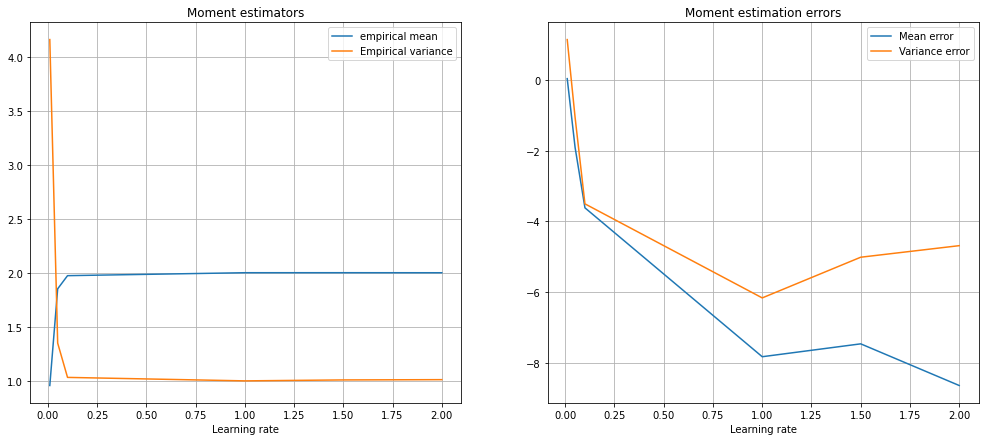

In [13]:
# Plotting results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plotting the results of the estimations
axs[0].plot(lambdas, mean_estim, label = "empirical mean")
axs[0].plot(lambdas, var_estim, label = "Empirical variance")
axs[0].set_title('Moment estimators')
axs[0].set_xlabel("Learning rate")
axs[0].legend()
axs[0].grid()

# Plotting the error of estimation
mean_error = abs(2 - np.array(mean_estim))
var_error = abs(1 - np.array(var_estim))

axs[1].plot(lambdas, np.log(mean_error), label = "Mean error")
axs[1].plot(lambdas, np.log(var_error), label = "Variance error")
axs[1].set_title('Moment estimation errors')
axs[1].set_xlabel("Learning rate")
axs[1].legend()
axs[1].grid()

# Show the plot
plt.show()


## $$ \mathcal{Conclusion} $$
The optimal learning rate is $ \lambda = 1 $  for **variance reduction**, and it gives very good estimation of the mean as well.

----

### Testing parameters that we judge to be optimal
Based on the previous results, we will adopt these parameters to see if they provide a good result or not: 
$$ N = 100, maxit = 500, \lambda = 1 $$

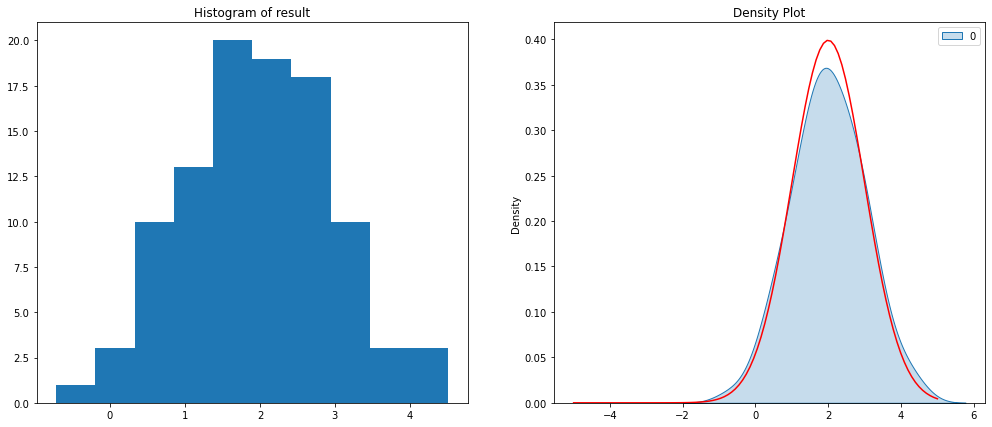

In [16]:
# Samples
X = gen_unif(100, 1, -5, 5)

# Parameters of the SVGD
h = 1e-6
lam = 1
sigma = 1
maxit = 500

# Performing SVGD
xf_optimal = SVGD_gauss(potential_N21, X, h, lam, sigma, maxit) 

# Plotting the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(xf_optimal)
axs[0].set_title('Histogram of result')

# Plot density and the theoretical one
sns.kdeplot(data = xf_optimal, fill=True, ax=axs[1], bw_method='silverman')
t = np.linspace(-5, 5, 100)
y = gauss_1d(t, 2, 1)
axs[1].plot(t, y, color="red", label="theoretical normal density")
axs[1].set_title('Density Plot')

# Show the plot
plt.show()

In [17]:
# The result of estimations
print("The empirical mean is : ", empirical_mean(xf_optimal))
print("The empirical variance is : ", empirical_variance(xf_optimal))

The empirical mean is :  1.9984375341163025
The empirical variance is :  0.9992944914847299


----
## What if we performed SVGD with the other kernel ?

We will use the other version of the **SVGD** algorithm using the band limited kernel. We can take at first $a = 1$

In [51]:
# Samples
X = gen_unif(100, 1, -5, 5)

# Parameters of the SVGD
h = 1e-6
lam = 0.005
a = 1
maxit = 500

# Performing SVGD
xf_band = SVGD_band(potential_N21, X, h, lam, a, maxit) 


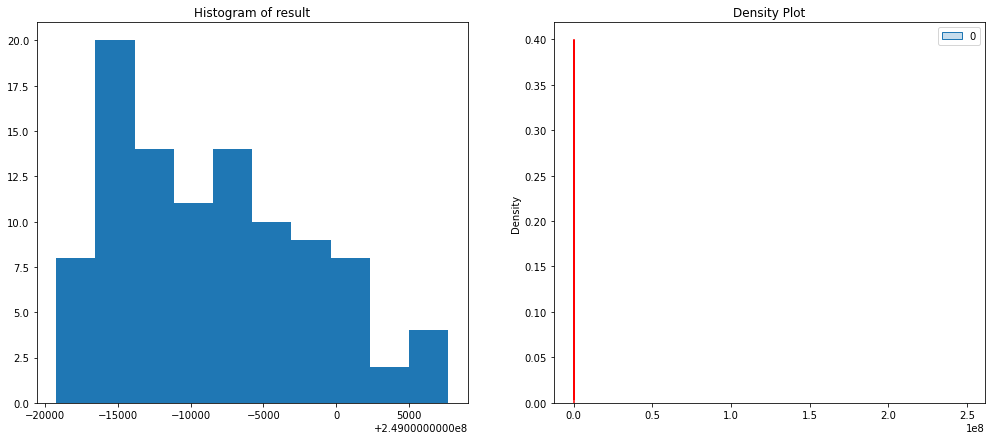

In [52]:
# Plotting the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(xf_band)
axs[0].set_title('Histogram of result')

# Plot density and the theoretical one
sns.kdeplot(data = xf_band, fill=True, ax=axs[1], bw_method='silverman')
t = np.linspace(-5, 5, 100)
y = gauss_1d(t, 2, 1)
axs[1].plot(t, y, color="red", label="theoretical normal density")
axs[1].set_title('Density Plot')

# Show the plot
plt.show()

In [53]:
# The result of estimations
print("The empirical mean is : ", empirical_mean(xf_band))
print("The empirical variance is : ", empirical_variance(xf_band))

The empirical mean is :  248991540.16844624
The empirical variance is :  44132026.73504537


## $$ \mathcal{Conclusion} $$
The performances are bad with this kernel !

---

## Trying to perform SVGD with another initial distribution

We will use a normal distribution $\mathcal{N}(7, 0.1)$ to see what we get as result with the same parameters

In [13]:
# Generate initial samples
X_new = np.zeros(100)
for i in range(100):
    X_new[i] = np.random.normal(loc = 7, scale = np.sqrt(0.1))

# Now perform SVGD on this new data
h = 1e-6
sigma = 1
maxit = 500
lam = 1

xf = SVGD_gauss(potential_N21, X_new, h, lam, sigma, maxit)

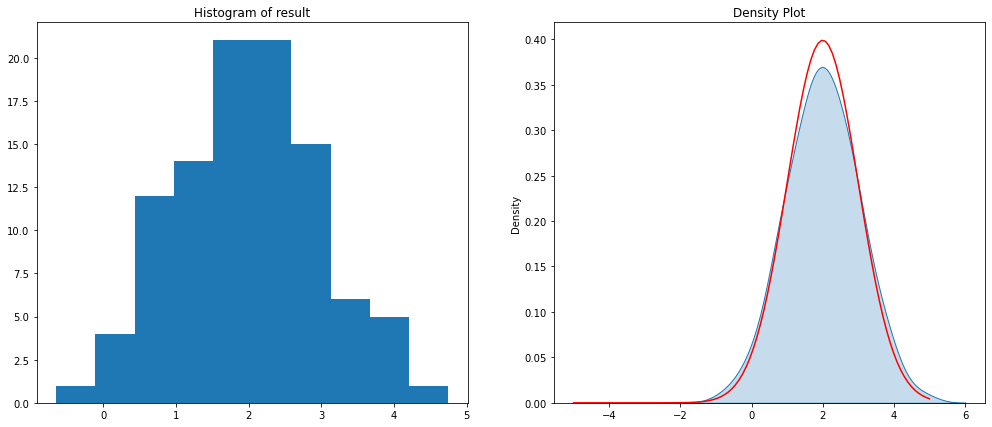

In [14]:
# Plotting the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(xf)
axs[0].set_title('Histogram of result')

# Plot density and the theoretical one
sns.kdeplot(data = xf, fill=True, ax=axs[1], bw_method='silverman')
t = np.linspace(-5, 5, 100)
y = gauss_1d(t, 2, 1)
axs[1].plot(t, y, color="red", label="theoretical normal density")
axs[1].set_title('Density Plot')

# Show the plot
plt.show()

In [15]:
# The result of estimations
print("The empirical mean is : ", empirical_mean(xf))
print("The empirical variance is : ", empirical_variance(xf))

The empirical mean is :  2.000642733897149
The empirical variance is :  1.0040495640377285


## $$ \mathcal{Conclusion} $$
We get very good results as well.

----

## Dimension 2:

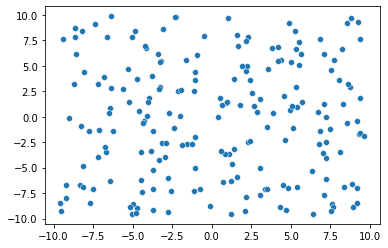

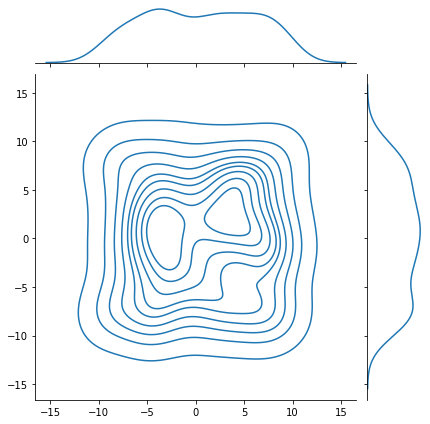

In [ ]:
X2 = genData(200,2) 
sns.scatterplot(x=X2.transpose()[0], y=X2.transpose()[1])
sns.jointplot(x = X2.transpose()[0], y=X2.transpose()[1], kind='kde') # for the uniform

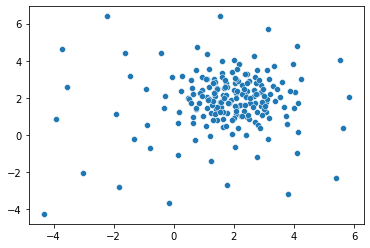

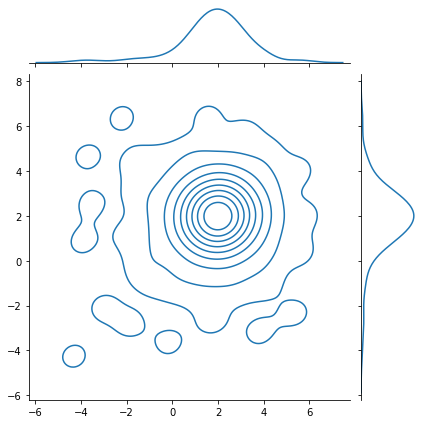

In [ ]:
# Now the particles obtained using SVGD
xf = SVGD(tar,X2,h,lam,sigma,100) # computation time: 2m47s avec 150 c'est 4m35
sns.scatterplot(x=xf.transpose()[0],y=xf.transpose()[1] )
sns.jointplot(x = xf.transpose()[0], y=xf.transpose()[1], kind='kde')


# Part 3: Langevin algorithm

In [54]:
def LA(F, h, ht, N): # ht est dans l'algo de Langevin, et h pour le gradient, N is the number of particles that we want at the end
    
    maxit = 500
    try:
        d = len(x0)
    except:
        d=1
    l = [] # list of realisations of Langevin
    for i in range(N):
        xf = np.random.uniform(low = -5, high = 5)
        t = 0
        while t < maxit: # Gradient descent
            xi = np.random.normal(loc = 0, scale = 1)
            xf = xf - ht*gradient(F, xf, h) + np.sqrt(2 * ht) * xi
            t+=1
        l.append(xf)

    return np.array(l)


## Testing of the algorithm on $\mathcal{N}(2, 1)$

<AxesSubplot:ylabel='Density'>

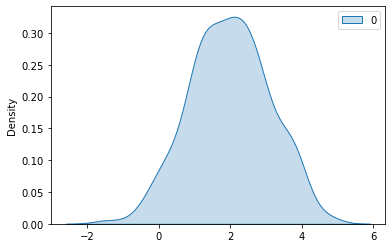

In [55]:
# Parameters of Langevin
ht = 0.1
h = 1e-6
N = 200

# Performing Langevin Monte Carlo
xf = LA(potential_N21, h, ht, N) # time : rapide: quelques secondes
sns.kdeplot(data = xf, fill=True)

In [56]:
# results of estimation
print("The empirical mean is : ", empirical_mean(xf))
print("The empirical variance is : ", empirical_variance(xf))

The empirical mean is :  1.9838770476253402
The empirical variance is :  1.225095301337698


-----
# Gaussian mixture

### What is a Gassian mixture:
If we denote by $f_{\mu, \sigma}$ the density if the Gaussian distribution $ \mathcal{N}(\mu, \sigma^2)$, then the density of a Gaussian mixture is Given by:
$$ p f_{\mu_1, \sigma_1} + (1 - p) f_{\mu_2, \sigma_2}  $$
And this function is the density if this random variable: 
\begin{equation}
X = 
\begin{cases}
Y & \text{if} & B = 1 \\
Z & \text{if} & B = 0
\end{cases}
\end{equation}
Where $$ B \sim Ber(p) $$
And $$ Y \sim \mathcal{N}(\mu_1, \sigma_1^2) , Z \sim \mathcal{N}(\mu_2, \sigma_2^2)$$

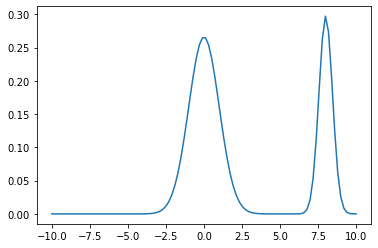

In [44]:
# defining a gaussian mixture function
def mix_gauss(x, mean1, mean2, sigma1,sigma2): # somme de normal N(1,2) et N(1.5,0.5)
    return (2/3) * gauss(x, mean1, sigma1) + (1/3) * gauss(x, mean2, sigma2)

mean1 = 0
mean2 = 8
sigma1 = 1
sigma2 = np.sqrt(0.2)
x = np.linspace(-10,10,100)
y = mix_gauss(x ,mean1, mean2, sigma1, sigma2)
plt.plot(x,y)
plt.show()


### A function to generate varibales following a gaussian mixture

In [46]:
def gen_gauss_mix(N, mean1, sigma1, mean2, sigma2, p):
    samples = np.zeros(N)
    for i in range(N):
        # Bernoulli 
        u = np.random.uniform(low = 0, high = 1)
        if u <= p: # distribution 1
            samples[i] = np.random.normal(loc = mean1 , scale = sigma1)
        else:
            samples[i] = np.random.normal(loc = mean2 , scale = sigma2)
    return samples
            

# Part 4: Comparison between Langevin and SVGD to generate Gaussian mixture

We will try to generate the Gaussian mixture with parameters:
$$ p = \frac{2}{3}, \mu_1 = 0, \sigma_1 = 1, \mu_2 = 7, \sigma_2 = \sqrt{0,2}$$

In [66]:
# Gaussian mixture target potential
def tar_mix(x): 
    return -np.log(mix_gauss(x, 0, 7, 1, np.sqrt(0.2)))


## Generating samples from Gaussian mixture:

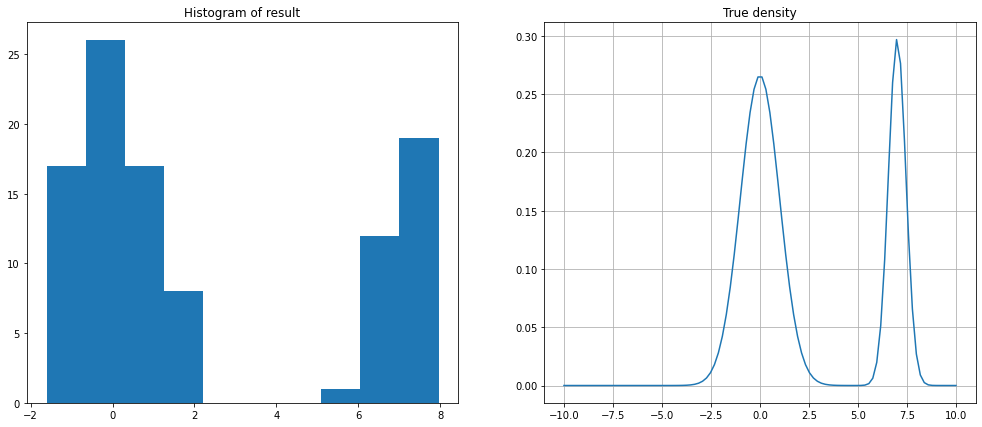

In [67]:
# Generate samples and see their empirical distibution and histogram
mean1 = 0
mean2 = 7
sigma1 = 1
sigma2 = np.sqrt(0.2)
p = 2 / 3
X = gen_gauss_mix(100, mean1, sigma1, mean2, sigma2, p)

# Plotting results
fig, axs = plt.subplots(nrows=1, ncols = 2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(X)
axs[0].set_title('Histogram of result')

# The true density
x = np.linspace(-10,10,100)
y = mix_gauss(x ,mean1, mean2, sigma1, sigma2)
axs[1].plot(x,y)
axs[1].set_title('True density')
axs[1].grid()

# Show the plot
plt.show()

In [68]:
# Result of estimators:
mask1 = (X < 5)
x1 = X[mask1]
mask2 = (X > 5)
x2 = X[mask2]
print("The estimation of mean 1 is : ", empirical_mean(x1))
print("The estimation of variance 1 is : ", empirical_variance(x1))
print("The estimation of mean 1 is : ", empirical_mean(x2))
print("The estimation of variance 1 is : ", empirical_variance(x2))

The estimation of mean 1 is :  0.07142459565495758
The estimation of variance 1 is :  0.9299049578832869
The estimation of mean 1 is :  7.101679934793655
The estimation of variance 1 is :  0.20230945699219746


## Testing Langevin on this Gaussian mixture

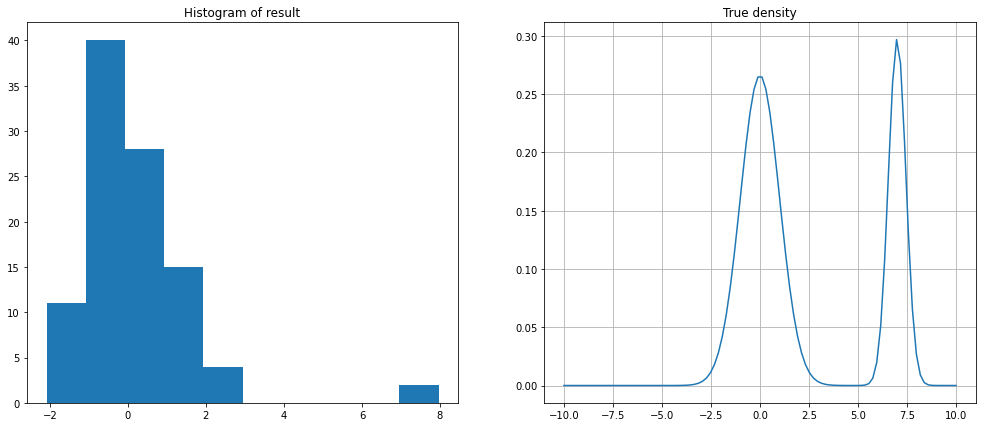

In [69]:
# Parameters of Lagevin
ht = 0.1
h = 1e-6
N = 100

# Performing Langevin Monte Carlo
xf_LA = LA(tar_mix, h, ht, N)

# Plotting the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(xf_LA)
axs[0].set_title('Histogram of result')

# Plot the theoretical density
x = np.linspace(-10,10,100)
y = mix_gauss(x ,mean1, mean2, sigma1, sigma2)
axs[1].plot(x,y)
axs[1].set_title('True density')
axs[1].grid()

# Show the plot
plt.show()

In [70]:
# Result of estimators:
mask1 = (xf_LA < 5)
x1 = xf_LA[mask1]
mask2 = (xf_LA > 5)
x2 = xf_LA[mask2]
print("The estimation of mean 1 is : ", empirical_mean(x1))
print("The estimation of variance 1 is : ", empirical_variance(x1))
print("The estimation of mean 1 is : ", empirical_mean(x2))
print("The estimation of variance 1 is : ", empirical_variance(x2))

The estimation of mean 1 is :  0.037023583614195416
The estimation of variance 1 is :  1.0830349252182092
The estimation of mean 1 is :  7.502391517768275
The estimation of variance 1 is :  0.4246563495433272


## $$ \mathcal{Conclusion}$$
Poor (very poor) estimation of the second gaussian

---

## Testing SVGD on the same Gaussian mixture

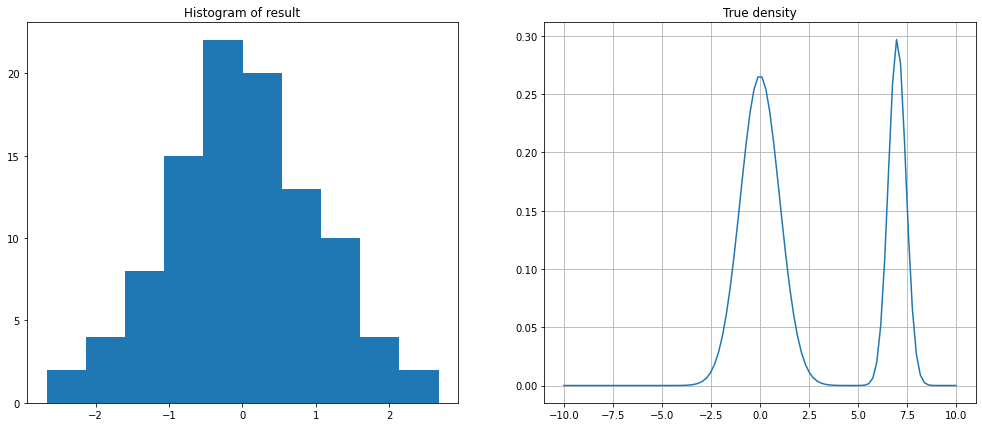

In [71]:
# Samples
X = gen_unif(100, 1, -5, 5)

# Parameters of the SVGD
h = 1e-6
lam = 1
sigma = 1
maxit = 500

# Performing SVGD
xf_mix = SVGD_gauss(tar_mix, X, h, lam, sigma, maxit) 

# Plotting the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(xf_mix)
axs[0].set_title('Histogram of result')

# Plot the True density
x = np.linspace(-10,10,100)
y = mix_gauss(x ,mean1, mean2, sigma1, sigma2)
axs[1].plot(x,y)
axs[1].set_title('True density')
axs[1].grid()

# Show the plot
plt.show()

In [72]:
# Result of estimators:
mask1 = (xf_mix < 5)
x1 = xf_mix[mask1]
mask2 = (xf_mix > 5)
x2 = xf_mix[mask2]
print("The estimation of mean 1 is : ", empirical_mean(x1))
print("The estimation of variance 1 is : ", empirical_variance(x1))
print("The estimation of mean 1 is : ", empirical_mean(x2))
print("The estimation of variance 1 is : ", empirical_variance(x2))

The estimation of mean 1 is :  3.170257492970174e-05
The estimation of variance 1 is :  1.003284296986425
The estimation of mean 1 is :  nan
The estimation of variance 1 is :  -0.0


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_7000/1539601834.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(x) / N


## $$ \mathcal{Conclusion}$$


----

# Part 5: Adding noise to SVGD
On va alors définir une nouvelle fonction qui s'appelle **svgd_bruit** dans laquelle on ajoute du bruit à chaque update.

Au début, on va essayer d'ajouter un bruit gaussien $ \mathcal{N}(0, b^2)$ et ensuite analyser les résultats.


In [ ]:
# Define the SVGD method with Gaussian noise
def SVGD_bruit(V, X, h, lam, sigma, b, maxit=150) : 
    # b is the standard deviation 
    # trajectory = []
    # trajectory.append(list(X))  
    Xf = X.copy() # la configuration finale
    t=0 # le nombre d'itérations de l'algorithme
    N = len(X)
    try:
        d = len(X[0])
    except:
        d=1
    #maxit = int(d**2/eps) 
    X0 = Xf.copy()
    while t<maxit:
        t+=1
        for i in range(N): # update data
            s = 0
            for j in range(N):
                xi = np.random.normal(loc = 0, scale = b)
                s += grad(V,Xf[j],h)*k(Xf[i],Xf[j],sigma) - grad2_k(Xf[j],Xf[i],sigma) + xi
            Xf[i] = Xf[i] -(lam/N)*s
    #trajectory.append(list(Xf))
    return Xf

### Simulation

On teste cette approche, et on essaye de converger vers la loi $\mathcal{N}(2,1)$

----
# Part 6: New algorithm: Kernelized Wasserstein Gradient Descent

- I am not sure that this algorithm does not exist, but I am sure that the SVGD version of it does not !
- Here are the details about this algorithm:

We recall the Wasserstein gradient flow :
$$ X_{n + 1} = X_n - \epsilon \nabla \log \left(\frac{\mu_n(X_n)}{\pi(X_n)}\right) $$

If we devolop it, and if we consider : $$ \pi \propto \exp(-F) $$
Then we get that the Wasserstein gradient descent algorithm is the following:

$$ X_{n + 1} = X_n - \epsilon (\nabla F(X_n) + \frac{\nabla \mu_n(X_n)}{\mu_n(X_n)}) $$

We are guaranteed that this flow converges to the target distibution $\pi$, but we do not know the density $\mu$ at each step, this is why we can propose to approximate it using kernel approximation. If we do this, we would get the following algorithm:

- Generate i.i.d samples $(X_0^i)_{1}^N \sim \mu_0$
- For n= 0, 1, ....:
    do the update : 
    
    $$ X_{n + 1}^i =  X_n^i - \epsilon \left(\nabla F(X_n^i) + \frac{\frac{1}{h} \sum_{j = 1}^N \nabla K \left(\frac{X_n^i - X_n^j}{h} \right) }{\sum_{j = 1}^N K \left( \frac{X_n^i - X_n^j}{h}\right)} \right) $$
    
- Let us try to implement it, and see the obtained results


In [8]:
# Kernelized langevin
def parcours_rech(X, F, maxit, eps, h, hk):
    """
    input : 
    - X : initialization
    - maxit : the maximum number of iterations
    - eps : epsilon
    - h : for the gradient of F
    - hk : la fenêtre du kernel
    
    return :
    Xf : the final configuration of points
    """
    
    Xf = X.copy()
    N = len(X)
    
    for t in range(maxit):
        for i in range(N):
            num = 0
            den = 0
            for j in range(N):
                num += gr_gauss_kernel(Xf[i], Xf[j], 1)
                den += gauss_kernel(Xf[i], Xf[j], 1)
                
            Xf[i] = Xf[i] - eps * (gradient(F, Xf[i], h) + num / (hk * den))
    return Xf

### Testing

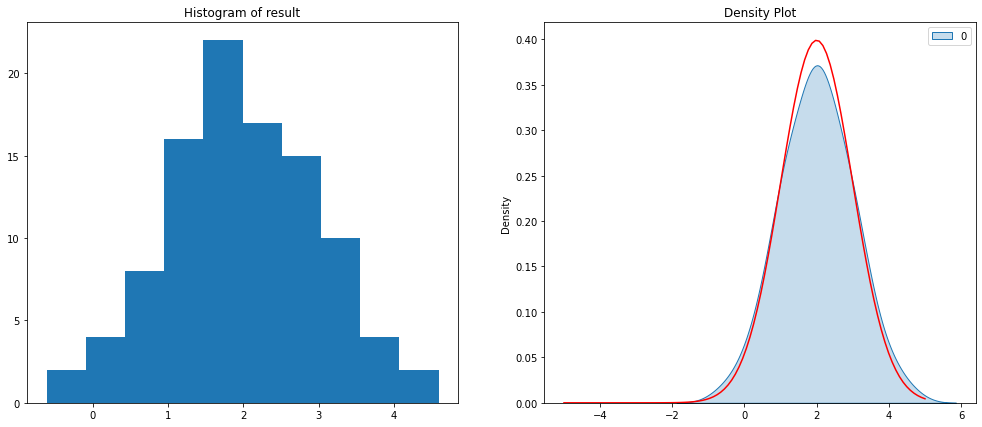

In [13]:
# Samples
X = gen_unif(100, 1, -5, 5)

# Simulation
maxit = 500
eps = 0.1
h = 1e-6
hk = 0.5

# Plotting results
xf = parcours_rech(X, potential_N21, maxit, eps, h, hk)

# Plotting the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(xf)
axs[0].set_title('Histogram of result')

# Plot density and the theoretical one
sns.kdeplot(data = xf, fill=True, ax=axs[1], bw_method='silverman')
t = np.linspace(-5, 5, 100)
y = gauss_1d(t, 2, 1)
axs[1].plot(t, y, color="red", label="theoretical normal density")
axs[1].set_title('Density Plot')


# Show the plot
plt.show()

# GREAT !

-----

Now let us implement its SVGD version !!

# Par ci par là: Schémas pour l'état de l'art

## Gradient descent scheme:

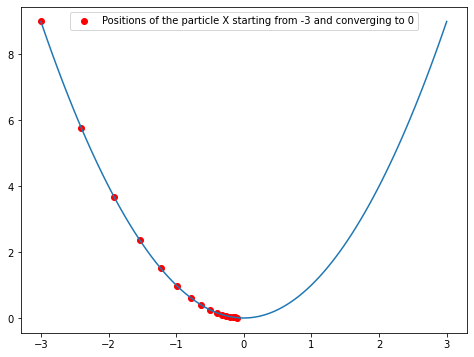

In [15]:
def f(x):
    return x**2

def gf(x):
    return 2*x
def desc(grad,gamma,x0, n):
    x = x0
    l = [x0]
    for i in range(n):
        x = x-gamma*grad(x)
        l.append(x)
    return np.array(l)

x0 = -3.
gamma = 0.1
n = 15
t = np.linspace(-3,3,100)
l = desc(gf,gamma,x0,n)
plt.figure(figsize=(8,6))
plt.plot(t, f(t))
plt.scatter(l,f(l), c='r', label='Positions of the particle X starting from -3 and converging to 0')
plt.legend()
plt.show()

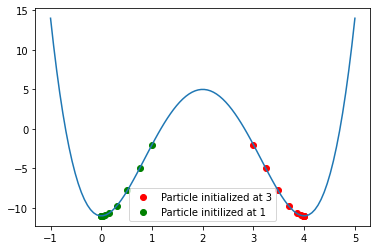

In [16]:
def F(x):
    return (x-2)**4 - 8*(x-2)**2 + 5

def grF(x):
    return 4*(x-2)**3 -16*(x-2)

t = np.linspace(-1,5,100)
gamma = 0.02
n = 10
x1 = 3
x2 = 1

l1 = desc(grF,gamma,x1,n)
l2 = desc(grF,gamma,x2,n)
plt.scatter(l1,F(l1),c='r',label='Particle initialized at 3')
plt.scatter(l2,F(l2),c='g',label='Particle initilized at 1')
plt.legend()
plt.plot(t,F(t))
plt.show()

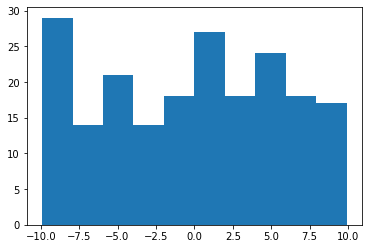

In [19]:
# Generating uniform variables
X = genData(200,1)
h = 1e-10
lam=1
sigma=1
maxit=150
plt.hist(X)

plt.show()

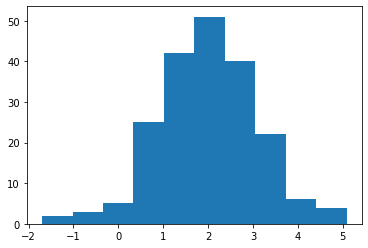

In [30]:
# Applying SVGD with noise to these variables

# standard deviation of the noise
b = 2

# Simulation
xf = SVGD_bruit(tar, X, h, lam, sigma, b, maxit) # expected time : 2m30s max
plt.hist(xf)
plt.show()

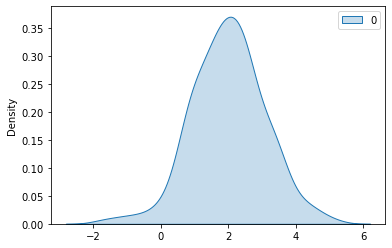

In [31]:
# Visualizing the density with seaborn
sns.kdeplot(data=xf, fill=True)
t = np.linspace(-1,5,100)


### Test with Gaussian mixture:

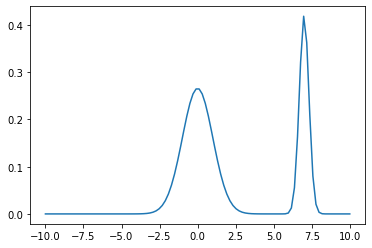

In [32]:
# Visualizing the target distribution
mean1 = 0
mean2 = 7
sigma1 = 1
sigma2 = np.sqrt(0.1)
x = np.linspace(-10,10,100)
y = mix_gauss(x,mean1,mean2,sigma1,sigma2)
plt.plot(x,y)
plt.show()


<AxesSubplot:ylabel='Density'>

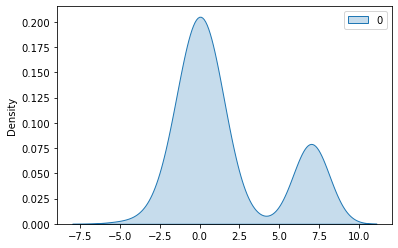

In [33]:
# Gauss mixture
xf = SVGD_bruit(tar2, X, h, lam, sigma, b, 200) # time : 27m12s for 500 iterations
sns.kdeplot(data=xf, fill=True)


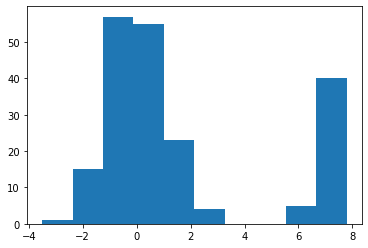

In [28]:
# Histograms
plt.hist(xf)
plt.show()